In [18]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats

class LinearRegression:
    def __init__(self, lr=0.001, n_iter=10000):
       self.lr = lr
       self.n_iter = n_iter
       self.weights = None
       self.bias = None

    '''
    This remvoes the outliers from the dataset
    '''
    def clean(self, X, z_score_thresh=2):
        ## remove outliers
        z_score = np.abs(stats.zscore(X))
        x = X[(np.abs( z_score < z_score_thresh)).all(axis=1)]
        return x
    def drop_target(self, X, target_name):
        ## remove target
        y = X[target_name]
        x = X.drop(columns=[target_name])
        return x,y
    def scale(self, X, target ="PT08.S1(CO)"):
        ## remove target
        if target in X.columns:
            X = X.drop(columns=[target])
        ## scale
        scaler = StandardScaler()
        x = scaler.fit_transform(X)
        return x
    
    def fit_ordinary_least_squares(self, X, y):
        '''
        - Implementation of ordinary least squares
        - calculates the weights and bias
        '''
        n_samples, n_features = X.shape
        X_transpose = X.T   
        self.weights = np.linalg.inv(X_transpose.dot(X)).dot(X_transpose).dot(y)
        self.bias = np.mean(y) - np.dot(X, self.weights)
        print(f"Weights: {self.weights}, Bias: {self.bias}")
        
    def fit(self, X, y):
        '''
        - Implementation of gradient descent
        - runs for n_iter iterations
        - calcualtes the predicted values using the current weights and bias
        - dw is the gradient of the loss function with respect to the weights
        - db is the gradient of the loss function with respect to the bias
        - updates the weights and bias using the gradients
        '''

        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for i in range(self.n_iter):
            y_predicted = np.dot(X, self.weights) + self.bias
            dw = (1/n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1/n_samples) * np.sum(y_predicted - y)
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
            # if i % 100 == 0:  # Print every 100 iterations
            #     print(f"Iteration {i}: Weights: {self.weights}, Bias: {self.bias}, dw: {dw}, db: {db}")

    def RSS(self, y, y_predicted):
            return np.sum((y - y_predicted) ** 2)
    def TSS(self, y):
        return np.sum((y - np.mean(y)) ** 2)
    def r2_score(self, y, y_predicted):
        return 1 - self.RSS(y, y_predicted) / self.TSS(y)

    def predict(self, X):
        y_predicted = np.dot(X, self.weights) + self.bias

        return y_predicted
    
    def residuals(self, y, y_predicted):
        return y - y_predicted
    
import numpy as np  
class LogisticRegression:
    def __init__(self, lr = 0.001, n_iter = 10000) -> None:
        self.lr = lr
        self.n_iter = n_iter
        self.weights = None
        self.bias = None

    '''
    The sigmoid function is used to map the output of the linear model to a value between 0 and 1.
    '''
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z)) 
    

    def fit(self, X,y):
        if not np.all(np.isin(y, [0, 1])):
            print("Array contains elements other than 0 or 1.")
            return -1
       

        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        for i in range(self.n_iter):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)
            dw = (1/n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1/n_samples) * np.sum(y_predicted - y)
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            # if i % 100 == 0:  # Print every 100 iterations
            #         print(f"Iteration {i}: Weights: {self.weights}, Bias: {self.bias}, dw: {dw}, db: {db}")
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return y_predicted_cls

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

'''
Perform a 5-fold cross validation.
Compute accuracy, precision, recall, and F1 score for each validation set across 5 folds. Report
the average and standard deviation of these metrics. Do you see a big change across different
folds?
'''
def k_fold_cross_validation(X, y, k=5):
    model = LogisticRegression()

    # Initialize 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # To store the results of each fold
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    iteration = 1
    # Perform cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train the model on the training set
        model.fit(X_train, y_train)
        
        ## predict on the test set
        y_pred = model.predict(X_test)
        
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        recall = recall_score(y_test, y_pred, zero_division=1)
        f1 = f1_score(y_test, y_pred, zero_division=1)
        
        # Append metrics for each fold
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        print(f"Iteration {iteration}: Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        iteration += 1
    # Report the average and standard deviation for each metric
    print(f"Accuracy: Mean = {np.mean(accuracy_list):.4f}, Std = {np.std(accuracy_list):.4f}")
    print(f"Precision: Mean = {np.mean(precision_list):.4f}, Std = {np.std(precision_list):.4f}")
    print(f"Recall: Mean = {np.mean(recall_list):.4f}, Std = {np.std(recall_list):.4f}")
    print(f"F1 Score: Mean = {np.mean(f1_list):.4f}, Std = {np.std(f1_list):.4f}")
'''
Perform a 5-fold cross validation.
Compute RMSE for each validation set across 5 folds. Report average and standard deviation
of RMSE values. Do you see a big change across different folds? How can you use the coefficient
of this model to find the most informative features?
'''
def k_fold_cross_validation_RMSE(X, y, k=5):
    model = LinearRegression()
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    rmse_list = []
    feature_importance = np.zeros(X.shape[1])  # To store sum of absolute coefficients
    
    for train_index, test_index in kf.split(X):
        # Use normal array indexing since X and y are numpy arrays
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Fit the model
        model.fit(X_train, y_train)
        ## what are the weights of the model
        print(f"Weights: {model.weights}, Bias: {model.bias}")
        y_pred = model.predict(X_test)
        
        # Calculate RMSE
        rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
        rmse_list.append(rmse)
        print(f"RMSE: {rmse:.4f}")
        # Sum absolute values of weights (coefficients)
        feature_importance += np.abs(model.weights)
    
    # Average feature importance across folds
    feature_importance /= k
    
    # Report RMSE mean and std
    print(f"RMSE: Mean = {np.mean(rmse_list):.4f}, Std = {np.std(rmse_list):.4f}")
    
    # Report most informative features
    feature_ranking = np.argsort(-feature_importance)  # Sort in descending order
    #print(f"Most informative features (by importance): {feature_ranking}")
    # most important feature
   
    return feature_ranking      

In [19]:
'''
(a) Data Processing (4 points)
'''
import pandas as pd

'''
1. Download and read the data. For Python, you may use pandas library and use read csv
function.
'''
train_data = pd.read_csv('data_train.csv')
test_data = pd.read_csv('data_test.csv')

'''
2. Print the first 5 rows of the data using the command. (You may use head() function in
pandas library). Print the shape of the training dataframe. Write a short description of
the data.
'''

print("This is the head of the training data")
print(train_data.head())
print("This is the shape of the training data")
print(train_data.shape)

# The target variable is PT08.S1(C0) and there are 11 features in the data set, in the training data the data freame has 13 columns, where 12 columns are the features and the last column just assigns a number to the row.
# There are 6250 rows of data.
#missing values

'''
Does the data have any missing values? How many are missing? Return the number of
missing values. (In pandas, check out isnul() and isnul().sum())
'''

print("train data missing values")
print(train_data.isnull().sum())
train_data = train_data.dropna()
print("train data missing values after dropping")
print(train_data.isnull().sum())
## each of the columns in the features have 77 missing values


print("test data missing values")
print(test_data.isnull().sum())
test_data = test_data.dropna()
print("test data missing values after dropping")
print(test_data.isnull().sum())



This is the head of the training data
   Unnamed: 0  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0           0        797.0    -200.0       2.1          593.0    146.0   
1           1       1282.0    -200.0      11.0         1013.0    354.0   
2           2        891.0    -200.0       7.6          882.0    342.0   
3           3       1285.0    -200.0      18.1         1243.0    481.0   
4           4        892.0    -200.0       7.3          869.0     71.0   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  
0        1212.0     72.0         984.0        494.0  10.8  49.7  0.6429  
1         545.0    141.0        1384.0       1287.0  17.4  50.6  0.9989  
2         885.0    149.0         950.0        894.0   7.8  33.9  0.3594  
3         599.0    173.0        1815.0       1582.0  26.4  41.9  1.4237  
4         953.0     77.0        1363.0        632.0  37.4  14.7  0.9295  
This is the shape of the training data
(6250, 13)
train data missing valu

In [20]:
'''
Extract the features and the label. The label is PT08.S1(CO)
(I extract this later when I seperate the data into X and y)
'''
X = train_data
print(X.head())
print("--------------------")
#print(label.head())



   Unnamed: 0  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0           0        797.0    -200.0       2.1          593.0    146.0   
1           1       1282.0    -200.0      11.0         1013.0    354.0   
2           2        891.0    -200.0       7.6          882.0    342.0   
3           3       1285.0    -200.0      18.1         1243.0    481.0   
4           4        892.0    -200.0       7.3          869.0     71.0   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  
0        1212.0     72.0         984.0        494.0  10.8  49.7  0.6429  
1         545.0    141.0        1384.0       1287.0  17.4  50.6  0.9989  
2         885.0    149.0         950.0        894.0   7.8  33.9  0.3594  
3         599.0    173.0        1815.0       1582.0  26.4  41.9  1.4237  
4         953.0     77.0        1363.0        632.0  37.4  14.7  0.9295  
--------------------


features before normalizing


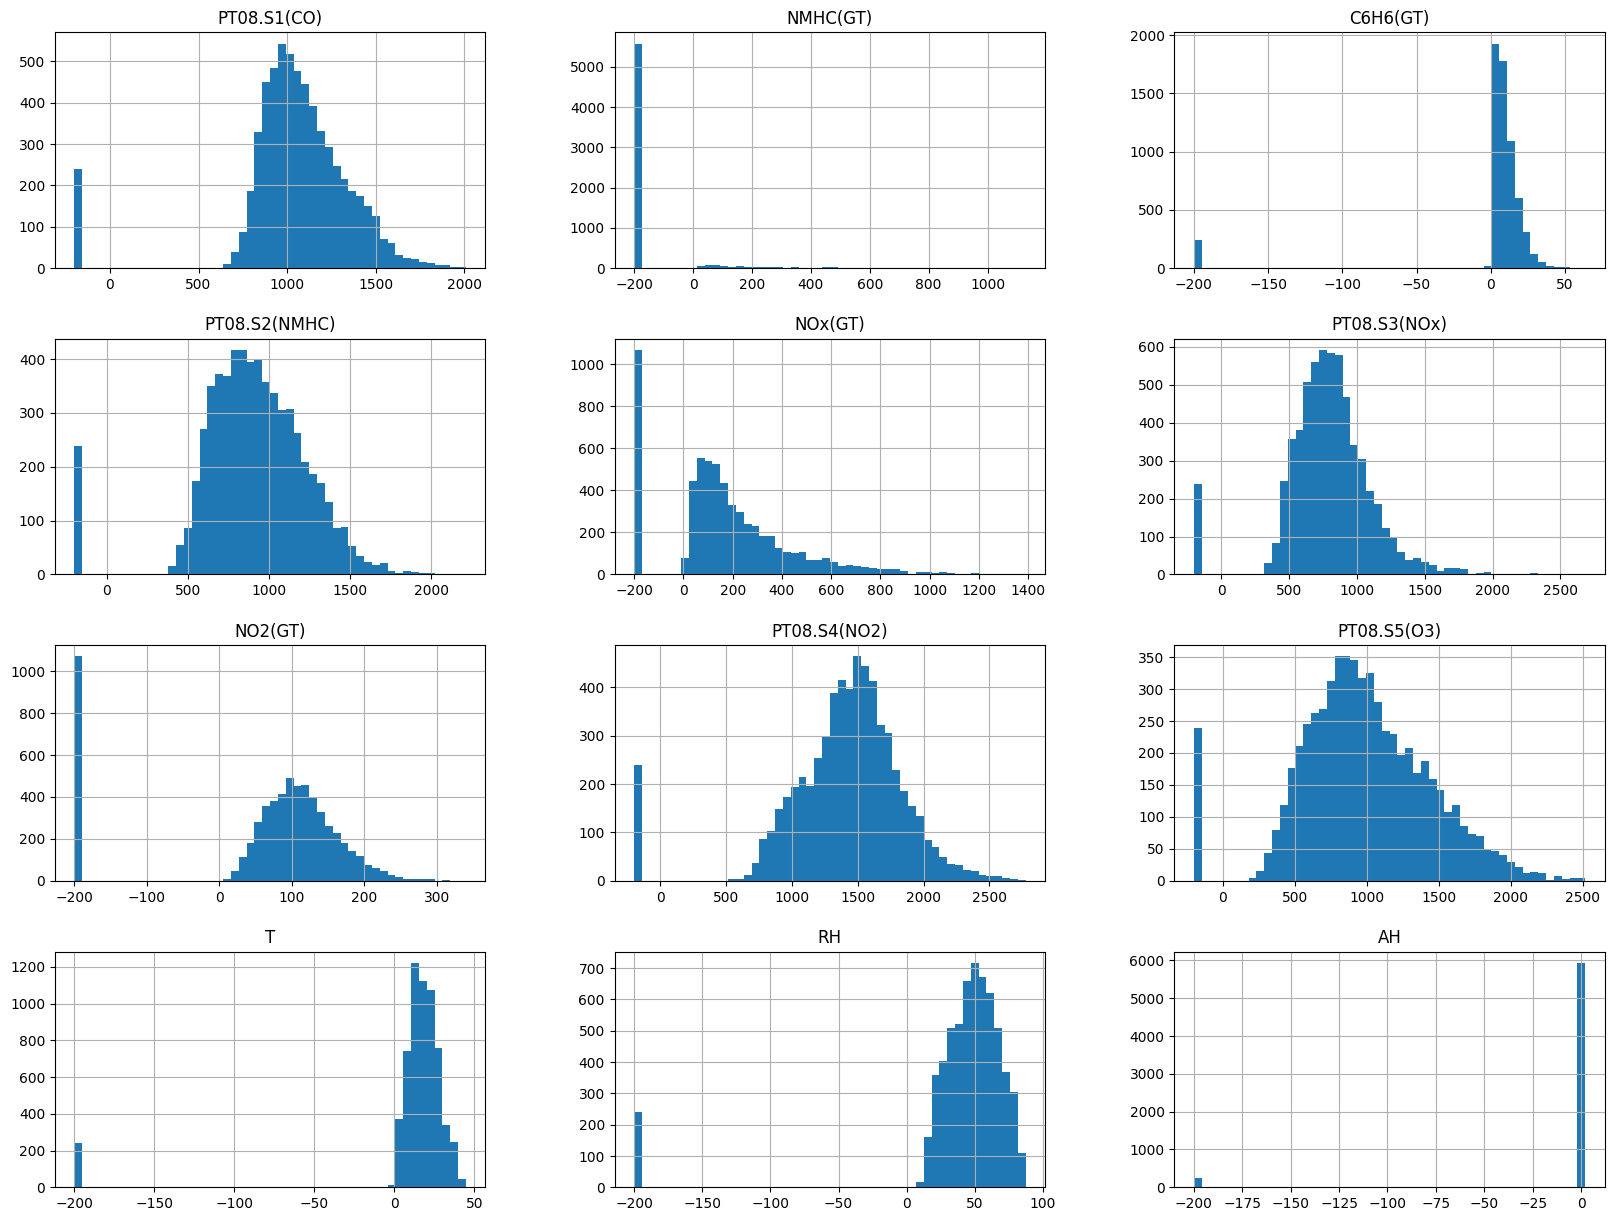

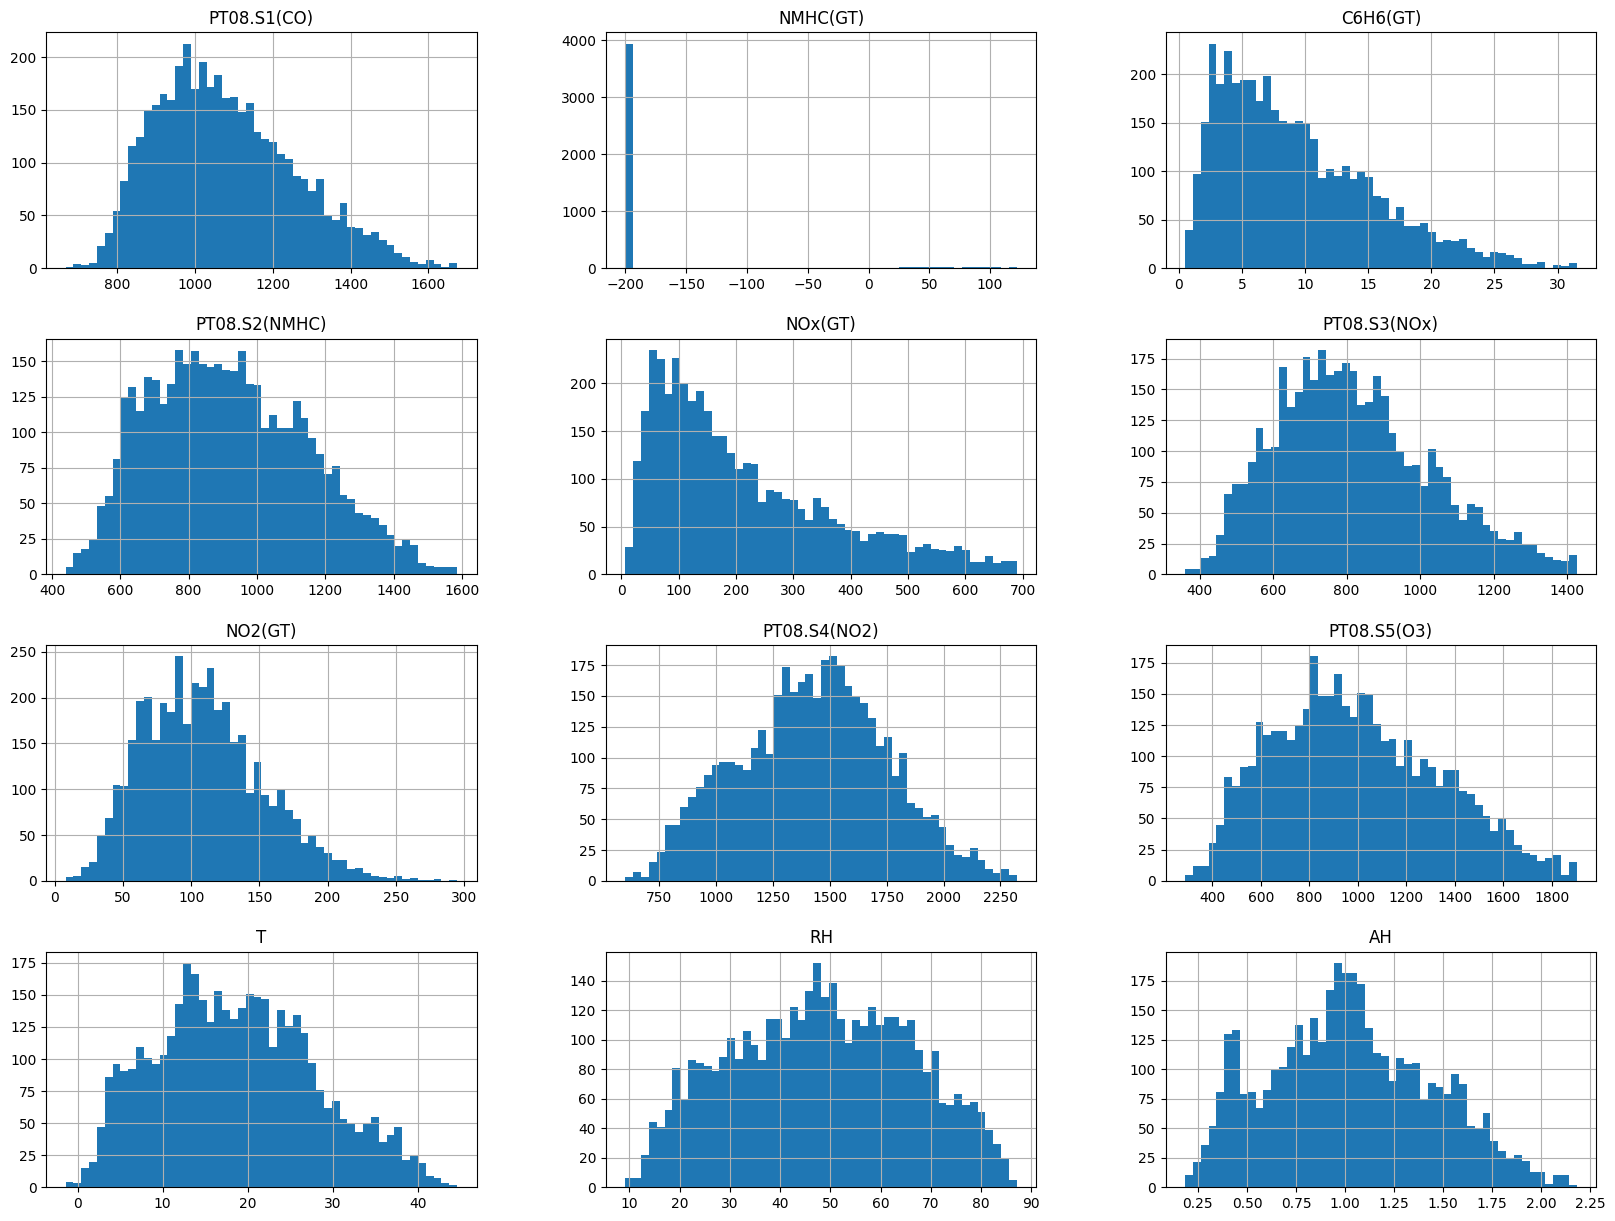

Scatter plot between PT08.S2(NMHC) and PT08.S4(NO2)


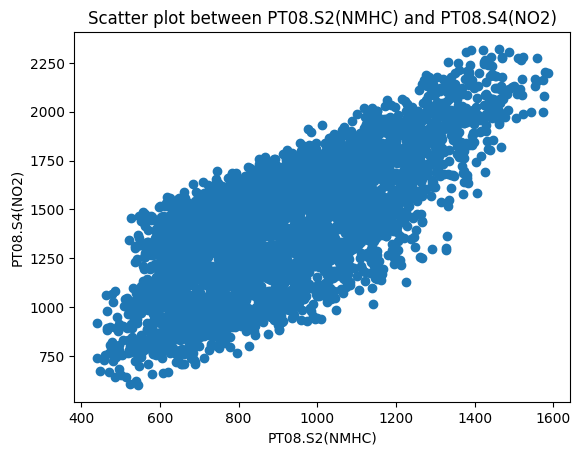

there seems to be a very high correlation between the two features


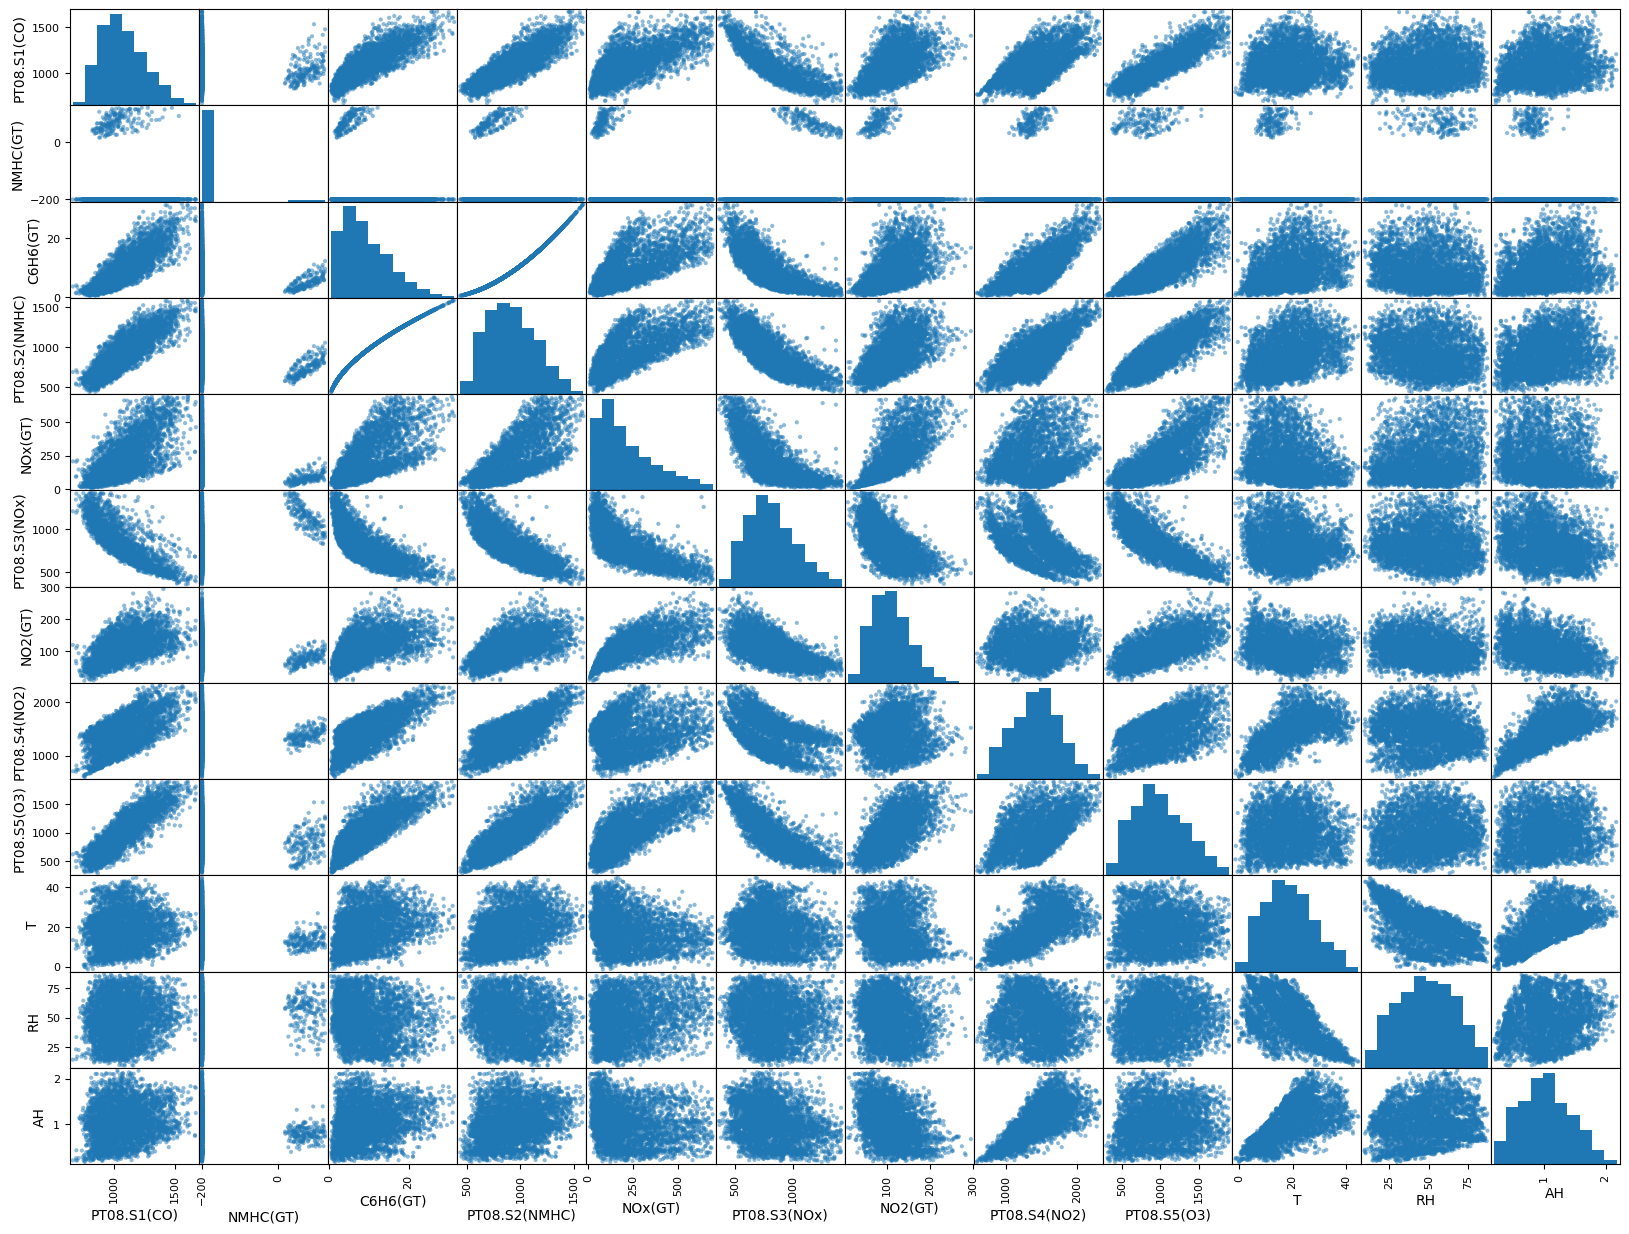

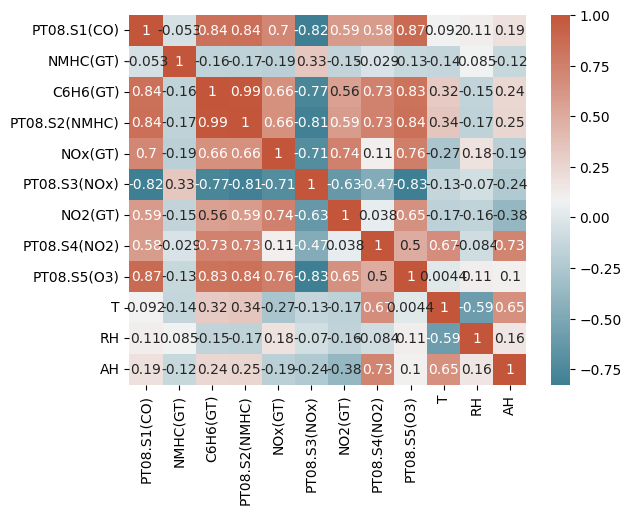

In [21]:
'''
(b) Exploratory Data Analysis (10 points)
'''
'''
Plot the histograms of all the features in the data. Do all the features have a normal
distribution? Do you see any outlier values? Do you need to apply any normalization
technique to these values? If so, you can transform your data in this step and explain
your thought process in the corresponding markdown cell
'''
## plot histgrams for all the features
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

linear_model = LinearRegression()

## drop first column "Unamed: 0"
if 'Unnamed: 0' in X.columns:
    X = X.drop('Unnamed: 0', axis=1)
print("features before normalizing")
X.hist(bins=50, figsize=(20,15)) ## bins is the number of bins to use in the histogram

# clean by removing outliers greater than 3 standard deviations from the mean
X_clean = linear_model.clean(X)
## Getting rid  of some outliers 
X_clean.hist(bins=50, figsize=(20,15))
plt.show()


'''
Pick 2 features and create a scatter plot to illustrate the correlation between these two
features. Is there a high correlation between these features?
'''
print("Scatter plot between PT08.S2(NMHC) and PT08.S4(NO2)")
plt.scatter(X_clean['PT08.S2(NMHC)'], X_clean['PT08.S4(NO2)'])
plt.xlabel('PT08.S2(NMHC)')
plt.ylabel('PT08.S4(NO2)')
plt.title('Scatter plot between PT08.S2(NMHC) and PT08.S4(NO2)')
plt.show()

print("there seems to be a very high correlation between the two features")
X_clean.head()


'''
Compute the Pearson’s correlation between all pairs of variables 1-12. Assign the resulting
correlation values in a 12x12 matrix C, whose (i; j) element represents the correlation value
between variables i and j, i.e., C(i; j) = corr(i; j). Visualize the resulting matrix C with a
heatmap and discuss potential associations between the considered variables. Note: You
can use the ‘heatmap’ function from ‘seaborn’
'''
from pandas.plotting import scatter_matrix
scatter_matrix(X_clean, figsize=(20,15))
plt.show()

import seaborn as sns
corr = X_clean.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.show()

In [22]:
'''
(c) (20 points) Linear Regression Implementation Implement a linear regression model
from scratch to regress the target variable, Carbon monoxide (CO). (Remember: You can not
use any libraries for the linear regression model.)
'''


## Dropping the target variable from the test data
X_clean, y_clean = linear_model.drop_target(X_clean, 'PT08.S1(CO)')
x_clean_scaled= linear_model.scale(X_clean)


linear_model.fit(x_clean_scaled, y_clean)
y_train_predicted = linear_model.predict(x_clean_scaled)
r2 = linear_model.r2_score(y_clean, y_train_predicted)
r2

np.float64(0.8519751747888675)

In [23]:
'''
(d)
Logistic Regression Implementation Using the column PT08.S1(CO),
create a binary label for this dataset where the values more than 1000 correspond to label 1
and the values less than or equal to 1000 correspond to label 0. Implement a logistic regression
model from scratch to predict this binary label. (Remember: You can not use any libraries
for the logistic regression model.)
'''

y_clean_log = np.where(y_clean <= 1000, 0, 1)
# y_clean_test_log = np.where(y_test_clean <= 1000, 0, 1)
print(y_clean_log[0:5])
print(y_clean[0:5])

logistic_model = LogisticRegression()
logistic_model.fit(x_clean_scaled, y_clean_log)
y_predicted_test_log = logistic_model.predict(x_clean_scaled)

if y_clean is not np.ndarray:
    y_clean = y_clean.to_numpy()


[0 1 0 1 0]
0     797.0
1    1282.0
2     891.0
3    1285.0
4     892.0
Name: PT08.S1(CO), dtype: float64


In [24]:
'''
(e) (10 points) Result Analysis - Linear Regression Perform a 5-fold cross validation.
Compute RMSE for each validation set across 5 folds. Report average and standard deviation
of RMSE values. Do you see a big change across different folds? How can you use the coefficient
of this model to find the most informative features?
(f ) (10 points) Result Analysis - Logistic Regression Perform a 5-fold cross validation.
Compute accuracy, precision, recall, and F1 score for each validation set across 5 folds. Report
the average and standard deviation of these metrics. Do you see a big change across different
folds?
'''


# Linear Regression 5-cross validation
print("------------------------------------")
print("Linear Regression 5-cross validation")
feature_ranking = k_fold_cross_validation_RMSE(x_clean_scaled, y_clean, 5)
print("------------------------------------")
# Logistic Regression 5-cross validation
print("Logistic Regression 5-cross validation") 
k_fold_cross_validation(x_clean_scaled, y_clean_log, 5)
print("------------------------------------")

print("LinearRegression questions")
print("There is no significant change in RMSE between folds, the variation is modest, which suggests that the model is stable and performs similarly across different subsets of the data. ")
print("Features with larger coefficients in absolute value are more important for determining the output, positive weights indicate that an increase in the future leads to an increase in predicted value, while negative weights mean that an increase in the feature leads to a decrease in the predicted value.")


print("LogisticRegression questions")
print("The changes across the different folds are small for all metrics (accuracy, precision, recall, and F1 score), as indicated by the low standard deviations. This suggests that the Logistic Regression model performs consistently across the different data splits.")


------------------------------------
Linear Regression 5-cross validation
Weights: [ 22.11636028  29.1593216   18.85813797  10.74101607 -46.00308589
  15.60324648  26.13956774  46.14825328  -2.33230212  19.02752888
  -2.2632205 ], Bias: 1078.5469488603928
RMSE: 68.9548
Weights: [ 23.39376311  28.60022843  19.22224523  12.66122827 -48.80320713
  14.89713608  27.77951087  43.44372818  -2.01278418  19.52091395
  -2.70900843], Bias: 1078.18704488706
RMSE: 73.4406
Weights: [ 22.64143666  27.87986804  18.60444018  13.05470395 -45.09294757
  16.84378567  29.20082157  44.92634125  -2.58152469  19.06277699
  -2.43312882], Bias: 1078.8782939016362
RMSE: 67.5344
Weights: [ 22.07643229  28.26913415  18.9321724   12.12787513 -48.46496
  13.49911678  28.53115085  44.59979427  -3.07663526  18.48851174
  -4.67185607], Bias: 1078.870260228125
RMSE: 66.7260
Weights: [ 23.35632513  26.20059783  20.11150857  13.12249336 -45.88997253
  17.03821875  30.32513488  42.15667251  -3.14797775  18.65450469
  -2.16

-------------------------------------------------
Cross validation results for sklearn logistic regression
Accuracy:  [0.91183575 0.90568319 0.91414752 0.89842805 0.89600967]
Precision:  [0.91856061 0.93083004 0.93177388 0.91362764 0.9039548 ]
Recall:  [0.94174757 0.91634241 0.92996109 0.92427184 0.93203883]
F1:  [0.93000959 0.92352941 0.9308666  0.91891892 0.91778203]
Average cross validation results for sklearn logistic regression
Accuracy:  0.9052208377874745
Precision:  0.919749393228791
Recall:  0.928872350874542
F1:  0.9242213093865308
-------------------------------------------------


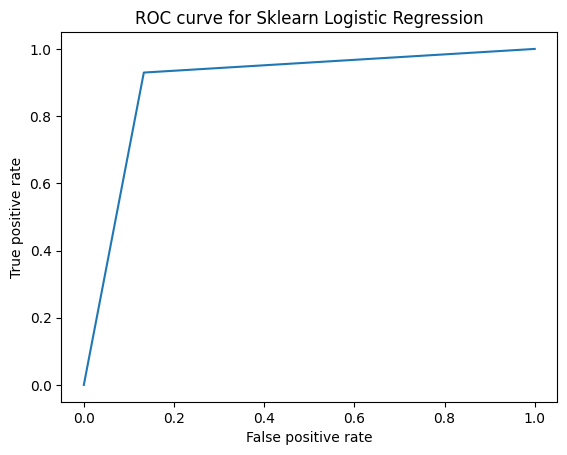

AUC for ROC Sklearn Logistic Regression 0.8982883425224643


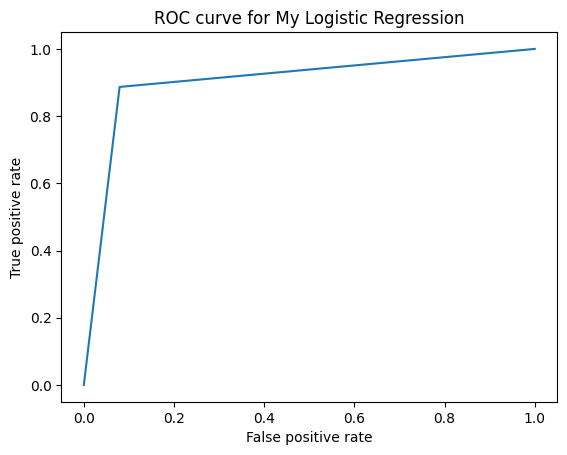

AUC for ROC My Logistic Regression 0.9037839177899138
The performance metrics (accuracy, precision, recall, F1 score) are quite consistent across both approaches. The differences between the manually implemented logistic regression and the sklearn logistic regression are minor, indicating that both models are correctly implemented and comparable in performance.
Both models yield comparable AUC values, indicating that the performance of the manually implemented logistic regression is consistent with that of the sklearn logistic regression model.


In [25]:
'''
(g)
ROC Curve - Logistic Regression Use the logistic regression model from
sklearn and repeat 5-fold cross validation. Then using roc curve package from sklearn.metrics,
plot the ROC curve for each fold and compute the area under the curve. Is this result consistent
with the results you obtained using the logistic regression model you implemented?
'''
from sklearn.linear_model import LogisticRegression as sklr
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import roc_curve, make_scorer, accuracy_score, precision_score, recall_score, f1_score

model = sklr()
model.fit(x_clean_scaled, y_clean_log)
y_train_predicted_ = model.predict(x_clean_scaled)

# do 5-cross validation from the sklean library on sklearn logistic regression
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}
cr_results = cross_validate(model, x_clean_scaled, y_clean_log, cv=5, scoring=scoring)
print("-------------------------------------------------")
print("Cross validation results for sklearn logistic regression")
print("Accuracy: ", cr_results['test_accuracy'])
print("Precision: ", cr_results['test_precision'])
print("Recall: ", cr_results['test_recall'])
print("F1: ", cr_results['test_f1'])

## printing out the average of the cross validation results
print("Average cross validation results for sklearn logistic regression")
print("Accuracy: ", cr_results['test_accuracy'].mean())
print("Precision: ", cr_results['test_precision'].mean())
print("Recall: ", cr_results['test_recall'].mean())
print("F1: ", cr_results['test_f1'].mean())
print("-------------------------------------------------")
# ROC curve for sklearn logistic regression
fpr, tpr, thresholds = roc_curve(y_clean_log, y_train_predicted_)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Sklearn Logistic Regression')
plt.show()

## calculate the AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_clean_log, y_train_predicted_)
print("AUC for ROC Sklearn Logistic Regression", auc)


# Roc curve using my logistic regression
y_train_predicted_ = logistic_model.predict(x_clean_scaled)
fpr, tpr, thresholds = roc_curve(y_clean_log, y_train_predicted_)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for My Logistic Regression')
plt.show()

## calculate the AUC
auc = roc_auc_score(y_clean_log, y_train_predicted_)
print("AUC for ROC My Logistic Regression", auc)
print("The performance metrics (accuracy, precision, recall, F1 score) are quite consistent across both approaches. The differences between the manually implemented logistic regression and the sklearn logistic regression are minor, indicating that both models are correctly implemented and comparable in performance.")
print("Both models yield comparable AUC values, indicating that the performance of the manually implemented logistic regression is consistent with that of the sklearn logistic regression model.")



In [26]:
'''
(h.1)
Use the trained linear regression model and predict the PT08.S1(CO) value for the test
data.
'''



linear_regress = LinearRegression()
#linear_regress.fit(x_clean_scaled, y_clean)

# Adjust the test data to have the same number of features as the training data
# drop the column "Unnamed: 0"
x_test = train_data.drop('Unnamed: 0', axis=1)

x_test_clean = linear_model.clean(x_test)
x_test_clean_scaled = linear_model.scale(x_test)
y_test_predicted = linear_model.predict(x_test_clean_scaled)
print(y_test_predicted)

# now put it out to a csv file
y_test_predicted = pd.DataFrame(y_test_predicted, columns=['pred_linear'])


[ 923.97349534 1170.21015926 1041.3382573  ... 1003.00628071 1012.74023399
 1233.89089376]


In [27]:
'''
(h.2)
use the trained logistic regression model and predict the PT08.S1(CO) binary value (the
same label you created in step d) for the test data
'''
# Use the logistic regression model to predict the test data
logistic_regress = LogisticRegression()
logistic_regress.fit(x_clean_scaled, y_clean_log)
y_test_predicted_log = logistic_regress.predict(x_test_clean_scaled)

## now save both the linear regression and logistic regression predictions in diff columns
y_test_predicted_log = pd.DataFrame(y_test_predicted_log, columns=['pred_logistic'])
y_test_predicted = pd.concat([y_test_predicted, y_test_predicted_log], axis=1)
y_test_predicted.to_csv('predictions.csv', index=False)


## Explanation of Each Cell

### 1. **Importing Libraries**
   - This cell imports necessary libraries such as `numpy`, `sklearn.preprocessing.StandardScaler`, and `scipy.stats`. These libraries will be used for mathematical operations, data preprocessing, and statistical calculations.

### 2. **Linear Regression Class**
   - Defines a custom `LinearRegression` class. The class implements the following:
     - **Constructor (`__init__`)**: Initializes the learning rate (`lr`), number of iterations (`n_iter`), weights, and bias.
     - **`clean` Method**: Cleans the dataset by removing outliers using a z-score threshold.
     - **`drop_target` Method**: Separates the target variable from the features.
     - **`scale` Method**: Standardizes the dataset (removes the mean and scales it to unit variance).
     - **`fit_ordinary_least_squares` Method**: Fits the model using Ordinary Least Squares (OLS) to calculate weights and bias.
     - **`fit` Method**: Fits the model using gradient descent to minimize loss.
     - **`RSS`, `TSS`, and `r2_score` Methods**: Compute residual sum of squares, total sum of squares, and R² score.
     - **`predict` Method**: Predicts the target values for new input data using the model weights and bias.
     - **`residuals` Method**: Computes the residuals between actual and predicted values.

### 3. **Logistic Regression Class**
   - Defines a custom `LogisticRegression` class. This class implements logistic regression for binary classification:
     - **Constructor (`__init__`)**: Initializes the learning rate, number of iterations, weights, and bias.
     - **`sigmoid` Method**: Implements the sigmoid function to map linear predictions to the range (0, 1).
     - **`fit` Method**: Uses gradient descent to adjust the weights and bias for classification.
     - **`predict` Method**: Classifies data by applying the sigmoid function and using a threshold of 0.5 to assign class labels (0 or 1).

### 4. **K-Fold Cross-Validation**
   - A function `k_fold_cross_validation` to perform 5-fold cross-validation for the logistic regression model, calculating and printing the accuracy, precision, recall, and F1 score for each fold, and reporting their means and standard deviations.

### 5. **K-Fold Cross-Validation for RMSE (Linear Regression)**
   - Implements the `k_fold_cross_validation_RMSE` function to perform 5-fold cross-validation for the linear regression model. It computes the Root Mean Square Error (RMSE) for each fold and reports the mean and standard deviation of RMSE. Additionally, it identifies the most informative features by summing the absolute values of the model's coefficients across folds.

### 6. **Data Preprocessing**
   - Loads the training and test datasets using Pandas.
   - Checks for missing values, removes rows with missing data, and prints the first five rows of the dataset. The data consists of 6250 rows with 13 columns, where the target variable is "PT08.S1(CO)".

### 7. **Exploratory Data Analysis (EDA)**
   - **Histograms**: Plots histograms for all features to check the distribution of data and identify outliers.
   - **Scatter Plot**: Creates a scatter plot between two features to examine correlations.
   - **Correlation Matrix**: Computes and visualizes the Pearson correlation matrix between features using a heatmap.

### 8. **Linear Regression Training**
   - Prepares the data by removing the target variable and scaling the features.
   - Trains the `LinearRegression` model using gradient descent and predicts the target values (`PT08.S1(CO)`). It also computes the R² score of the model.

### 9. **Logistic Regression Training**
   - Converts the target variable into a binary classification task based on a threshold of 1000 for `PT08.S1(CO)`.
   - Trains a custom `LogisticRegression` model on the scaled data and predicts the binary labels for the dataset.

### 10. **Cross-Validation Results**
   - **Linear Regression**: Performs 5-fold cross-validation to compute the RMSE across folds, prints the model weights, and ranks features based on their importance.
   - **Logistic Regression**: Performs 5-fold cross-validation for logistic regression, calculating accuracy, precision, recall, and F1 score across folds, and reporting their averages and standard deviations.

### 11. **ROC Curve and AUC**
   - Uses both the custom and `sklearn` logistic regression models to plot the Receiver Operating Characteristic (ROC) curve and compute the Area Under the Curve (AUC). The results are compared between the custom implementation and the `sklearn` implementation.

### 12. **Prediction on Test Data**
   - **Linear Regression**: Uses the trained linear regression model to predict `PT08.S1(CO)` on the test dataset.
   - **Logistic Regression**: Uses the trained logistic regression model to predict the binary classification of `PT08.S1(CO)` on the test dataset.
   - The results are saved to a CSV file.
